In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, brier_score_loss, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [11]:
class DataExplorer:
    def __init__(self, train_dir, val_dir, test_dir):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir

    def get_image_statistics(self):
        subsets = {'Train': self.train_dir, 'Validation': self.val_dir, 'Test': self.test_dir}
        stats = {}
        for subset, dir_path in subsets.items():
            stats[subset] = {}
            for label in os.listdir(dir_path):
                label_dir = os.path.join(dir_path, label)
                if os.path.isdir(label_dir):
                    num_images = len(os.listdir(label_dir))
                    stats[subset][label] = num_images
        return stats

    def get_patient_statistics(self):
        patient_stats = {}
        for subset in ['train', 'val']:
            subset_dir = getattr(self, f'{subset.lower()}_dir')
            patient_stats[subset] = {}
            for label in os.listdir(subset_dir):
                if label != 'NORMAL':
                    label_dir = os.path.join(subset_dir, label)
                    if os.path.isdir(label_dir):
                        patient_ids = [fname.split('_')[0] for fname in os.listdir(label_dir)]
                        unique_patients = set(patient_ids)
                        patient_stats[subset][label] = len(unique_patients)
        return patient_stats

    def display_sample_images(self, num_images=5):
        fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))
        for i, subset in enumerate(['train', 'val']):
            subset_dir = getattr(self, f'{subset.lower()}_dir')
            for j, label in enumerate(os.listdir(subset_dir)):
                label_dir = os.path.join(subset_dir, label)
                if os.path.isdir(label_dir):
                    images = [os.path.join(label_dir, img) for img in os.listdir(label_dir)[:num_images]]
                    for k, img_path in enumerate(images):
                        img = cv2.imread(img_path)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        axes[k, j].imshow(img)
                        axes[k, j].set_title(f'{subset} - {label}')
                        axes[k, j].axis('off')
        plt.show()

In [12]:
class DataExplorer:
    def __init__(self, train_dir, val_dir, test_dir):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir

    def get_image_statistics(self):
        subsets = {'Train': self.train_dir, 'Validation': self.val_dir, 'Test': self.test_dir}
        stats = {}
        for subset, dir_path in subsets.items():
            stats[subset] = {}
            for label in os.listdir(dir_path):
                label_dir = os.path.join(dir_path, label)
                if os.path.isdir(label_dir):
                    num_images = len(os.listdir(label_dir))
                    stats[subset][label] = num_images
        return stats

    def get_patient_statistics(self):
        patient_stats = {}
        for subset in ['train', 'val']:
            subset_dir = getattr(self, f'{subset.lower()}_dir')
            patient_stats[subset] = {}
            for label in os.listdir(subset_dir):
                if label != 'NORMAL':
                    label_dir = os.path.join(subset_dir, label)
                    if os.path.isdir(label_dir):
                        patient_ids = [fname.split('_')[0] for fname in os.listdir(label_dir)]
                        unique_patients = set(patient_ids)
                        patient_stats[subset][label] = len(unique_patients)
        return patient_stats

    def display_sample_images(self, num_images=5):
        fig = sp.make_subplots(rows=num_images, cols=2, subplot_titles=["Train", "Validation"], vertical_spacing=0.1)
        for i, subset in enumerate(['train', 'val']):
            subset_dir = getattr(self, f'{subset.lower()}_dir')
            col = i + 1
            for j, label in enumerate(os.listdir(subset_dir)):
                label_dir = os.path.join(subset_dir, label)
                if os.path.isdir(label_dir):
                    images = [os.path.join(label_dir, img) for img in os.listdir(label_dir)[:num_images]]
                    for k, img_path in enumerate(images):
                        img = cv2.imread(img_path)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        fig.add_trace(go.Image(z=img), row=k+1, col=col)

        fig.update_layout(height=400*num_images, title_text="Sample Images", showlegend=False)
        fig.show()

In [13]:
class ChestXRayClassifier:
    def __init__(self, img_size=224, batch_size=64):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None

    def load_data(self, train_dir, val_dir, test_dir):
        # Image data generators
        self.datagen_train = ImageDataGenerator(
            rescale=1./255,         # Normalize the image to [0, 1]
            rotation_range=10,      # Random rotations from -10 to 10 degrees
            width_shift_range=0.1,  # Random horizontal shifts up to 10% of the image width
            height_shift_range=0.1, # Random vertical shifts up to 10% of the image height
            shear_range=0.1,        # Shear transformations
            zoom_range=0.1,         # Random zooming up to 10%
            horizontal_flip=True,   # Enable horizontal flipping
            fill_mode='nearest'     # Fill in new pixels after a rotation or width/height shift
        )
        self.datagen_val_test = ImageDataGenerator(rescale=1./255)

        # Load train, validation, and test data
        self.train_generator = self.datagen_train.flow_from_directory(
            train_dir,
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=True
        )
        self.val_generator = self.datagen_val_test.flow_from_directory(
            val_dir,
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False
        )
        self.test_generator = self.datagen_val_test.flow_from_directory(
            test_dir,
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False
        )

    def build_model(self, initial_layer_freezed_ratio=0.80, learning_rate=0.001):
        # initial_layer_freezed_ratio: the ratio of initial layers to freeze
        # Load the DenseNet121 model pre-trained on ImageNet
        #base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(self.img_size, self.img_size, 3))
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(self.img_size, self.img_size, 3))
        base_model.trainable = True
        # Freeze the initial layers based on the fine_tune_ratio
        num_layers = len(base_model.layers)
        num_layers_to_freeze = int(num_layers * initial_layer_freezed_ratio)
        for layer in base_model.layers[:num_layers_to_freeze]:
            layer.trainable = False

        # Add custom layers on top of the base model
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        #x = Dense(256, activation='relu')(x) #Dense(1024, activation='relu')(x)
        predictions = Dense(1, activation='sigmoid')(x)

        # Define the model
        self.model = Model(inputs=base_model.input, outputs=predictions)

        # Compile the model with a specified learning rate
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    def train_model(self, epochs=40, early_stopping_patience=5):

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', 
                                       patience=early_stopping_patience, 
                                       restore_best_weights=True)

        self.model.fit(self.train_generator, 
                        validation_data=self.val_generator, 
                        epochs=epochs,
                        callbacks=[early_stopping])

    def generate_predictions(self, subset='val'):
        if subset == 'val':
            print('Generating predictions on validation set...')
            self.val_generator.reset()
            generator = self.val_generator
        elif subset == 'test':
            print('Generating predictions on test set...')
            self.test_generator.reset()
            generator = self.test_generator
        else:
            raise ValueError('subset must be either "val" or "test"')
        
        # Generate predictions
        preds = self.model.predict(generator)
        y_true = generator.classes
        return preds, y_true
    

    def enhance_calibration(self):
        print('Enhancing calibration using Platt Scaling on the validation set...')
        self.val_generator.reset()
        preds = self.model.predict(self.val_generator)
        y_true = self.val_generator.classes

        # Fit logistic regression for Platt Scaling
        platt_model = LogisticRegression()
        platt_model.fit(preds.reshape(-1, 1), y_true)
        return platt_model

    def expected_calibration_error(self, samples, true_labels, M=5):
        bin_boundaries = np.linspace(0, 1, M + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        confidences = np.max(samples, axis=1)
        predicted_label = np.argmax(samples, axis=1)
        accuracies = predicted_label == true_labels

        ece = np.zeros(1)
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
            prob_in_bin = in_bin.mean()

            if prob_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
        return ece
        
    def evaluate_and_plot(self, preds, y_true, title, pos):
        # Calculate metrics
        auc = roc_auc_score(y_true, preds)
        balanced_acc = balanced_accuracy_score(y_true, preds.round())
        tn, fp, fn, tp = confusion_matrix(y_true, preds.round()).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        balanced_acc2 = (sensitivity + specificity) / 2
        brier = brier_score_loss(y_true, preds)
        prob_true, prob_pred = calibration_curve(y_true, preds, n_bins=10)
        ece=self.expected_calibration_error(preds, y_true, M=10)[0]

        # Plot calibration curve
        plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label=title)
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
        plt.xlabel('Mean predicted probability')
        plt.ylabel('Fraction of positives')
        plt.title(title)
        plt.legend()

        # Display metrics
        metrics_text = (
            f'AUC: {auc:.2f}\n'
            f'Balanced Accuracy: {balanced_acc:.2f}\n'
            f'Balanced Accuracy 2: {balanced_acc2:.2f}\n'
            f'Sensitivity: {sensitivity:.2f}\n'
            f'Specificity: {specificity:.2f}\n'
            f'Brier Score: {brier:.2f}\n'
            f'ECE: {ece:.2f}'
        )
        positions = {1: (0.48, 0.55), 2: (0.98, 0.55), 3: (0.48, 0.15), 4: (0.98, 0.15)}
        plt.figtext(*positions[pos], metrics_text, horizontalalignment='right')


    def combined_calibration_plots(self, case):
        fig, axs = plt.subplots(2, 2, figsize=(15, 15))

        # Validation set before Platt Scaling
        self.val_generator.reset()
        preds_val = self.model.predict(self.val_generator)
        y_true_val = self.val_generator.classes
        plt.sca(axs[0, 0])
        self.evaluate_and_plot(preds_val, y_true_val, 'Validation Set Before Platt Scaling', 1)

        # Validation set after Platt Scaling
        platt_model = self.enhance_calibration()
        platt_preds_val = platt_model.predict_proba(preds_val.reshape(-1, 1))[:, 1]
        platt_preds_val = platt_preds_val.reshape(-1, 1)
        plt.sca(axs[0, 1])
        self.evaluate_and_plot(platt_preds_val, y_true_val, 'Validation Set After Platt Scaling', 2)

        # Test set before Platt Scaling
        self.test_generator.reset()
        preds_test = self.model.predict(self.test_generator)
        y_true_test = self.test_generator.classes
        plt.sca(axs[1, 0])
        self.evaluate_and_plot(preds_test, y_true_test, 'Test Set Before Platt Scaling', 3)

        # Test set after Platt Scaling
        platt_preds_test = platt_model.predict_proba(preds_test.reshape(-1, 1))[:, 1]
        platt_preds_test = platt_preds_test.reshape(-1, 1)
        plt.sca(axs[1, 1])
        self.evaluate_and_plot(platt_preds_test, y_true_test, 'Test Set After Platt Scaling', 4)

        plt.tight_layout()
        plt.savefig(f'calibration_plots_{case}.png')
        plt.show()

    def save_model(self, root_model_name):
        # Save model architecture and weights separately
        model_weights_path = f"{root_model_name}.keras"
        self.model.save(model_weights_path)
            


In [14]:
root_path = 'chest_xray'
eda = DataExplorer(root_path + '/train', root_path + '/val', root_path + '/test')

In [15]:
stats = eda.get_image_statistics()
stats

{'Train': {'NORMAL': 1341, 'PNEUMONIA': 3875},
 'Validation': {'NORMAL': 8, 'PNEUMONIA': 8},
 'Test': {'NORMAL': 234, 'PNEUMONIA': 390}}

In [16]:
stats2 = eda.get_patient_statistics()
stats2

{'train': {'PNEUMONIA': 1635}, 'val': {'PNEUMONIA': 7}}

In [17]:
classifier = ChestXRayClassifier()
classifier.load_data(train_dir=root_path + '/train', val_dir=root_path + '/val', test_dir=root_path + '/test')
classifier.build_model(initial_layer_freezed_ratio=0.80, learning_rate=0.001)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Training model 1 with initial_layer_freezed_ratio=0.2...
Epoch 1/15


d:\Formation\AI_FOR_MEDECINE\CHEST_CLASSIFCATION\venv_chest\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 676s 8s/step - accuracy: 0.9237 - loss: 0.1700 - val_accuracy: 0.5000 - val_loss: 11.7746
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 631s 8s/step - accuracy: 0.9758 - loss: 0.0679 - val_accuracy: 0.9375 - val_loss: 0.5623
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 625s 8s/step - accuracy: 0.9827 - loss: 0.0450 - val_accuracy: 0.8125 - val_loss: 0.4963
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 600s 7s/step - accuracy: 0.9854 - loss: 0.0416 - val_accuracy: 0.8125 - val_loss: 0.5163
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 599s 7s/step - accuracy: 0.9882 - loss: 0.0327 - val_accuracy: 1.0000 - val_loss: 0.0187
Epoch 6/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 599s 7s/step - accuracy: 0.9922 - loss: 0.0258 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 601s 7s/step - accuracy: 0.9883 - loss: 0.0307 - val_accuracy: 0.8125 - val_loss: 0.5213
Epoch 8/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 600s 7s/step - accuracy: 0.9917 - loss: 0.0247 - val_accuracy: 0.9375 - val_loss: 0

d:\Formation\AI_FOR_MEDECINE\CHEST_CLASSIFCATION\venv_chest\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


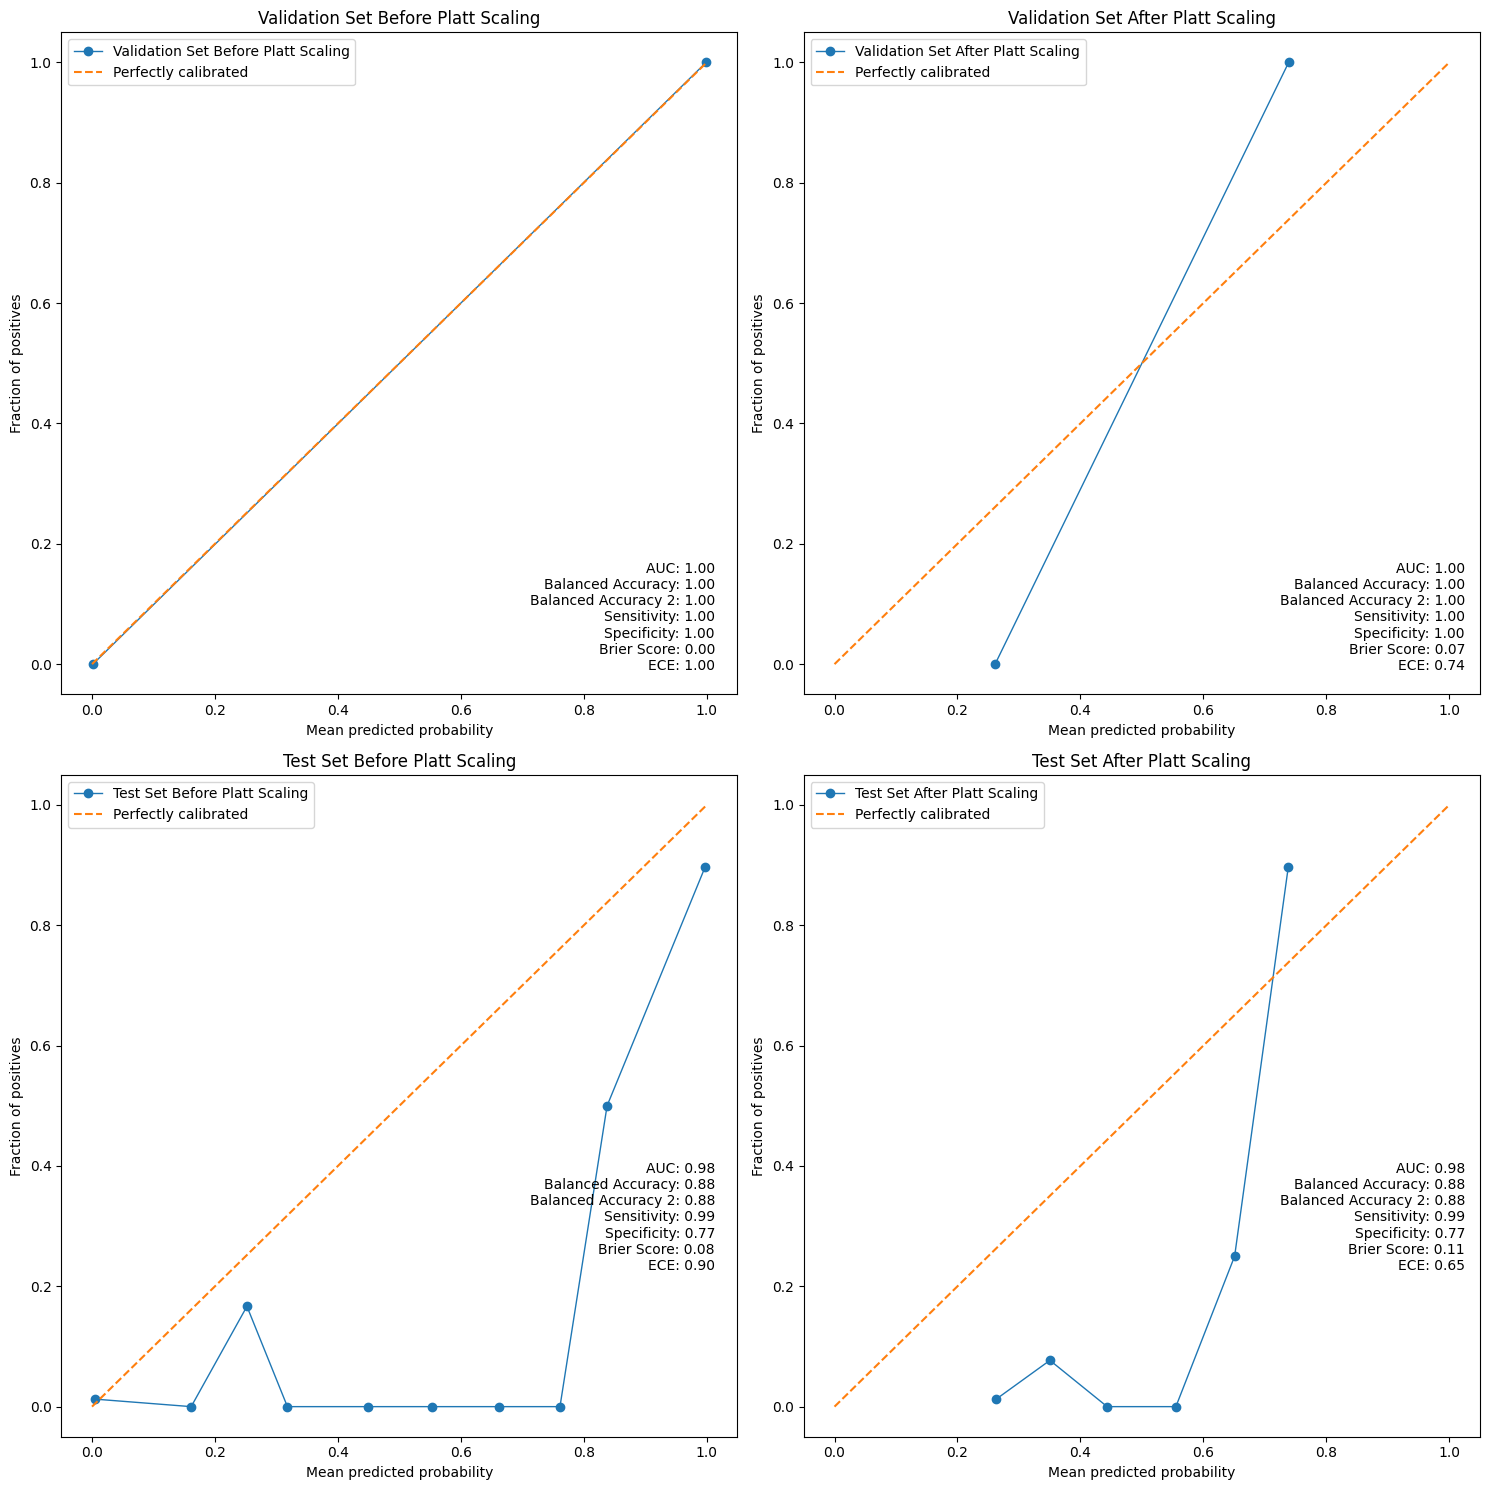

Training model 2 with initial_layer_freezed_ratio=0.3...
Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 12888s 159s/step - accuracy: 0.9058 - loss: 0.2014 - val_accuracy: 0.5000 - val_loss: 8.2961
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 477s 6s/step - accuracy: 0.9778 - loss: 0.0616 - val_accuracy: 0.8750 - val_loss: 0.3907
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 476s 6s/step - accuracy: 0.9796 - loss: 0.0552 - val_accuracy: 0.5625 - val_loss: 2.3165
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 476s 6s/step - accuracy: 0.9866 - loss: 0.0353 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 476s 6s/step - accuracy: 0.9909 - loss: 0.0291 - val_accuracy: 1.0000 - val_loss: 5.4832e-04
Epoch 6/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 477s 6s/step - accuracy: 0.9865 - loss: 0.0334 - val_accuracy: 0.8750 - val_loss: 0.1351
Epoch 7/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 476s 6s/step - accuracy: 0.9908 - loss: 0.0275 - val_accuracy: 1.0000 - val_loss: 4.4423e-04
Epoch 8/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 517s

In [18]:
initial_layer_freezed_ratio_list = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i, initial_layer_freezed_ratio in enumerate(initial_layer_freezed_ratio_list):
    print(f'Training model {i+1} with initial_layer_freezed_ratio={initial_layer_freezed_ratio}...')
    classifier.build_model(initial_layer_freezed_ratio=initial_layer_freezed_ratio, learning_rate=0.001)
    classifier.train_model(epochs=15, early_stopping_patience=5)
    classifier.save_model(f'chest_xray_model_{i}')
    classifier.combined_calibration_plots(i)
    

In [ ]:
# #train the model
# classifier.train_model(epochs=1, early_stopping_patience=1)
# # save the model
# classifier.save_model('model_chest_xray')

d:\Formation\AI_FOR_MEDECINE\CHEST_CLASSIFCATION\venv_chest\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 557s 6s/step - accuracy: 0.9270 - loss: 0.1849 - val_accuracy: 1.0000 - val_loss: 0.0613


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Display preds_val
[[0.05742782]
 [0.00804044]
 [0.03268324]
 [0.00426271]
 [0.12253993]
 [0.203339  ]
 [0.01412559]
 [0.00180213]
 [0.99985844]
 [0.9996139 ]
 [0.97221804]
 [0.75111675]
 [0.99734956]
 [0.9995791 ]
 [0.9775384 ]
 [0.85061985]]
Enhancing calibration using Platt Scaling on the validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


d:\Formation\AI_FOR_MEDECINE\CHEST_CLASSIFCATION\venv_chest\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step


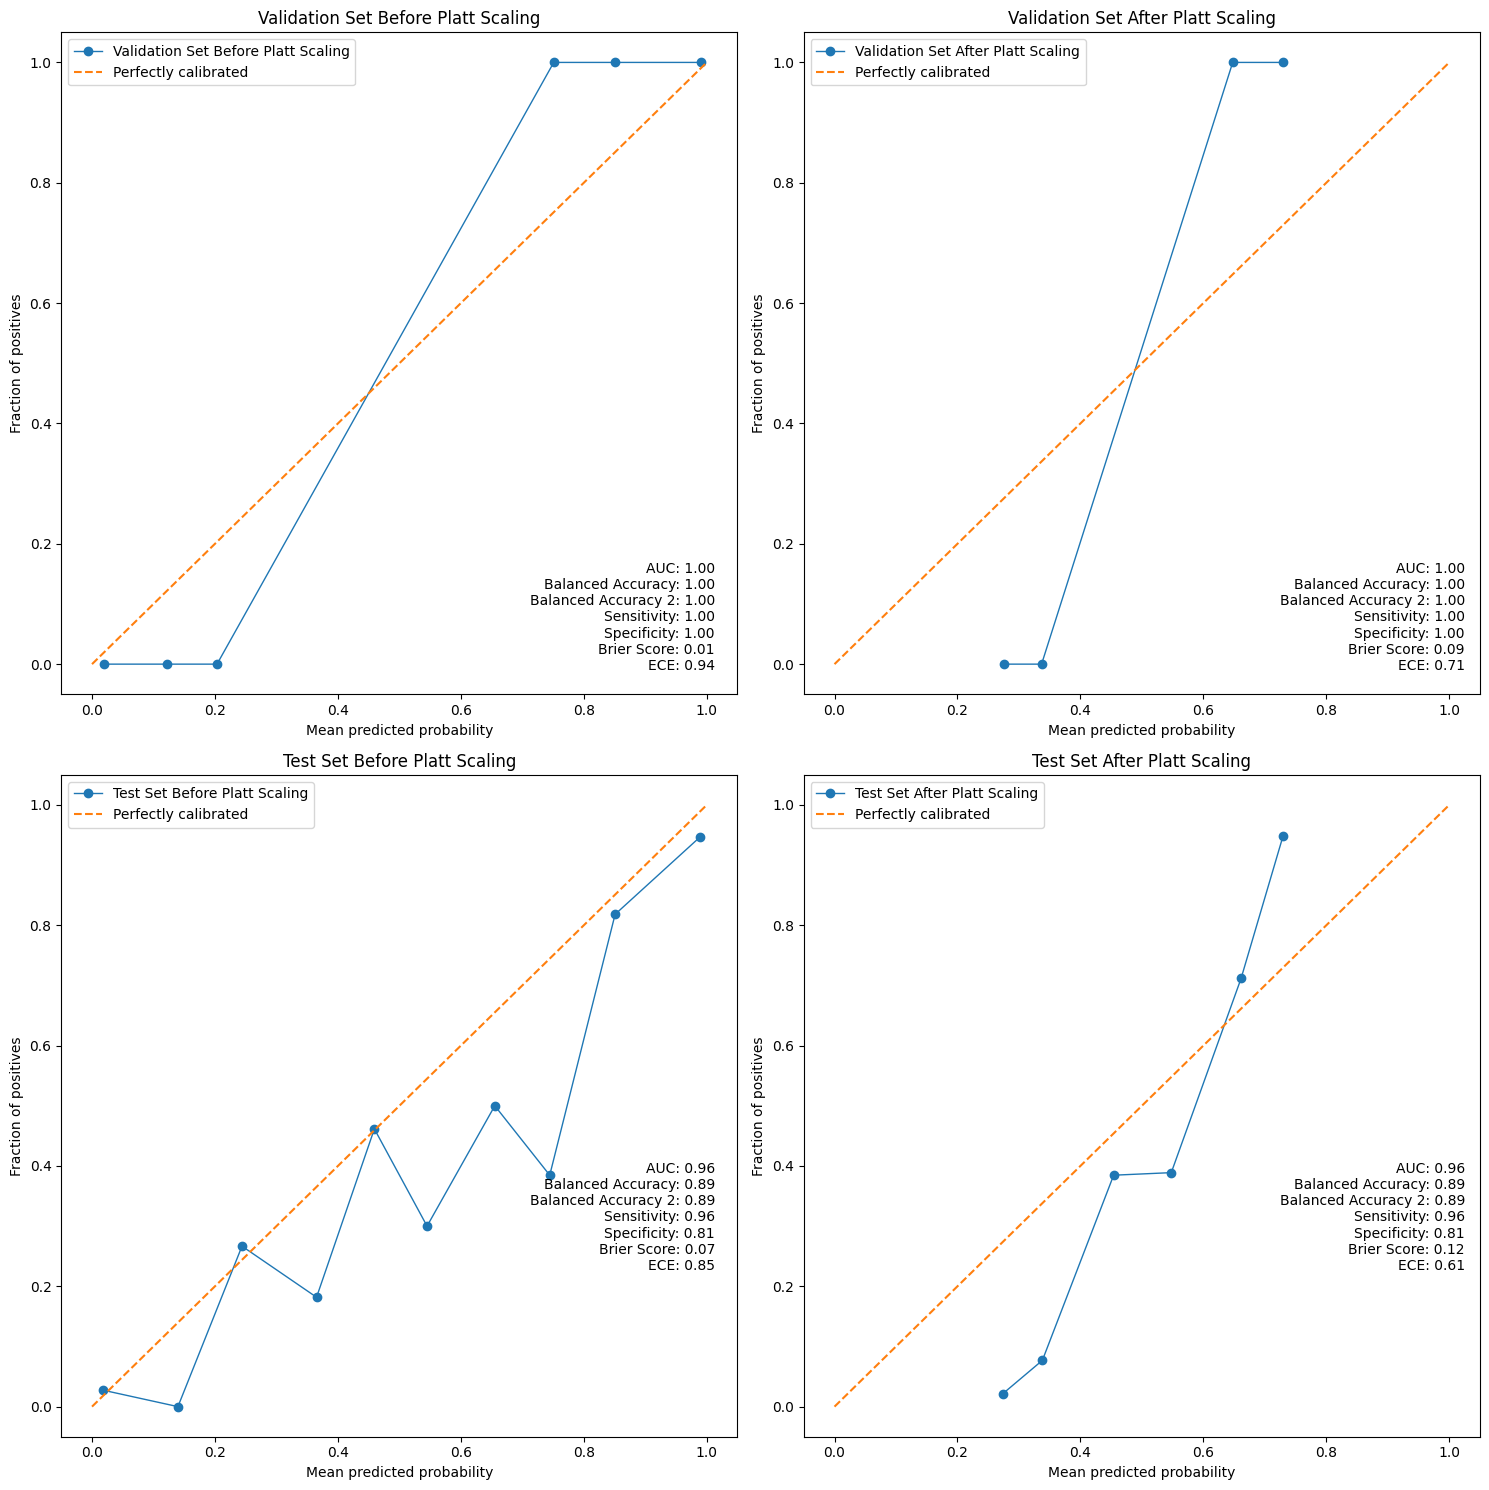

In [ ]:
# classifier.combined_calibration_plots()